# Interactive loading of PHOENIX NewEra pickled synthetic stellar spectra
Model grids published in The NewEra model grid ([Hauschildt _et al_., 2025](https://ui.adsabs.harvard.edu/abs/2025arXiv250417597H))

Data and sample code published at [DOI: 10.25592/uhhfdm.16727](https://doi.org/10.25592/uhhfdm.17156).

In [1]:
import numpy as np
#%matplotlib widget 
import matplotlib.pyplot as plt

from deblib.constants import c

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


### Load the pickled spectra/interp numpy array
The source NewEra h5 spectra files are located at [https://www.fdr.uni-hamburg.de/record/16738/files/](https://www.fdr.uni-hamburg.de/record/16738/files/).
The set of files for Z=0 are downloaded into `.cache/.newera_spectra` with the `download_newera_spectra.py` module
(at the expense of ~90 GiB disk space).

The module `parse_newera_spectra.py` parses these into a numpy structured array. The fluxes are
published as `scipy` `interp1d` instances (with `x` based on frequency) in a column named
`flux_interp`. The array is saved in a pickle which is loaded here.

In [2]:
# Load the Z==0 table created by parse_newera_spectra.py (either from numpy.save or pkl.dump)
table = np.load("libs/data/newera/PHOENIX-NewEra-LR.Z-0.0.npy", allow_pickle=True)

count_spec = len(table)
teff_from, teff_to = table["teff"].min(), table["teff"].max()
logg_from, logg_to = table["logg"].min(), table["logg"].max()
print(f"Loaded previously built, Z=0 NewEra spectra table containing {count_spec} spectra")
print(f"covering Teff from {teff_from} to {teff_to} K and logg from {logg_from} to {logg_to} dex")

Loaded previously built, Z=0 NewEra spectra table containing 852 spectra
covering Teff from 2300.0 to 12000.0 K and logg from 0.0 to 6.0 dex


### Plot the spectrum

In [3]:
# Selection criteria
teff = 5750
logg = 4.3

# Find the rows with the nearest Teff
teff_best_diff = table[np.argmin(np.abs(table["teff"]-teff))]["teff"] - teff
teff_mask = (table["teff"]+teff_best_diff == teff) | (table["teff"]-teff_best_diff == teff)

# And select the row with the nearest logg
row = table[teff_mask][np.argmin(np.abs(table[teff_mask]["logg"]-logg))]

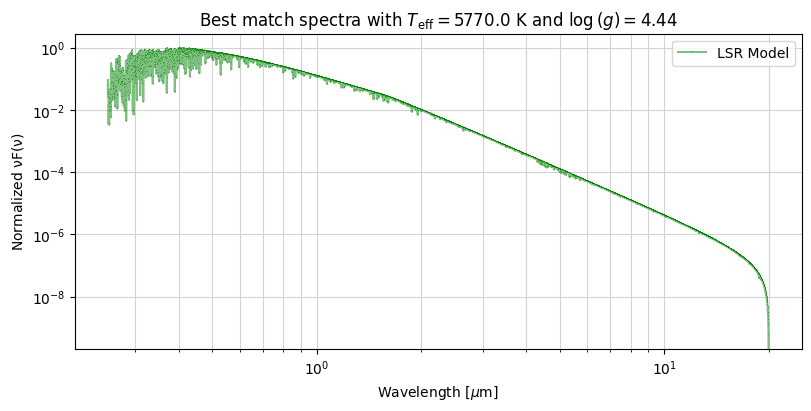

In [4]:
# Prep the spectrum
plot_lambdas = np.logspace(np.log10(row["lam_from"]), np.log10(row["lam_to"]), 5000)[:-1]
plot_freq = c*1e6 / plot_lambdas
vfv = row["flux_interp"](plot_freq) * plot_freq
norm_vfv = (vfv - vfv.min()) / (vfv.max() - vfv.min())

title = f"Best match spectra with $T_{{\\rm eff}}={row['teff']}$ K and $\\log{{(g)}}={row['logg']}$"
fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
ax.loglog(plot_lambdas, norm_vfv, ",-g", alpha=0.5, label="LSR Model")
ax.set(title=title, xlabel=r"Wavelength [$\mu$m]", ylabel=r"Normalized ${\rm \nu F(\nu)}$")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)